In [1]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from scipy.spatial import cKDTree
import open3d as o3d

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pc_seg.pc_label_map import color_map_dict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Invert the colormap to get RGB → label index
rgb_to_label = {tuple(v[0]): k for k, v in color_map_dict.items()}
label_to_name = {k: v[1] for k, v in color_map_dict.items()}

def get_label_from_color(color_array):
    """Match color to closest known semantic color label."""
    labels = []
    for c in color_array:
        # Round to 3 decimals to avoid float precision mismatch
        key = tuple(np.round(c, 3))
        label = rgb_to_label.get(key, -1)  # -1 if unmatched
        labels.append(label)
    return np.array(labels)

In [3]:
# Load the ground truch point cloud

#hexagon_path = r"C:\Users\yanpe\OneDrive - Metropolia Ammattikorkeakoulu Oy\Research\data\hexagon\Fira- 1001.ply"
smartlab_path = "../docs/SmartLab_2024_E57_Single_5mm_SEG_colors.ply"

gt_pcd = o3d.io.read_point_cloud(smartlab_path)   # ground truth point cloud with full resolution


In [11]:
o3d.visualization.draw_geometries([gt_pcd], point_show_normal=False)

In [4]:
def print_label_counts(label_array, name="Point Cloud"):
    print(f"\n📦 Label counts for {name}:")
    unique_labels, counts = np.unique(label_array, return_counts=True)
    total_points = len(label_array)
    for label, count in zip(unique_labels, counts):
        class_name = label_to_name.get(label, f"Class {label}")
        percentage = (count / total_points) * 100
        print(f"  {label:2d} ({class_name:10s}): {count:6d} points ({percentage:5.2f}%)")

In [4]:
# Move the point cloud to its min(x,y,z) corner
 
def move_to_corner(points):    
    # Find the minimum x, y, z
    min_xyz = points.min(axis=0)
    # Translate the point cloud so that the min corner becomes the origin
    moved_points = points - min_xyz
    
    return moved_points

moved_points = move_to_corner(np.array(gt_pcd.points))
gt_pcd.points = o3d.utility.Vector3dVector(moved_points)

In [5]:
# Extract point coordinates and colors
gt_points = np.asarray(gt_pcd.points)
gt_origin_colors = np.asarray(gt_pcd.colors)
gt_colors = np.round(gt_origin_colors, 1)

# Convert color to semantic labels
gt_labels = get_label_from_color(gt_colors)

In [7]:
# Ground Truth
print(f'{len(gt_points)} in total')
print_label_counts(gt_labels, name="Ground Truth")

# Prediction
#print_label_counts(pred_labels, name="Prediction")

35966772 in total

📦 Label counts for Ground Truth:
   0 (ceiling   ): 5701035 points (15.85%)
   1 (floor     ): 5167644 points (14.37%)
   2 (wall      ): 11348550 points (31.55%)
   4 (column    ): 173882 points ( 0.48%)
   5 (window    ): 549543 points ( 1.53%)
   6 (door      ): 1451390 points ( 4.04%)
   7 (table     ): 243330 points ( 0.68%)
   8 (chair     ):  99590 points ( 0.28%)
   9 (sofa      ): 190263 points ( 0.53%)
  11 (board     ): 488769 points ( 1.36%)
  12 (clutter   ): 10552776 points (29.34%)


In [8]:
def visualize_label_distribution(label_array, label_to_name, title="Label Distribution"):
    unique_labels, counts = np.unique(label_array, return_counts=True)
    total_points = len(label_array)
    
    labels = [label_to_name.get(label, f"Class {label}") for label in unique_labels]
    percentages = (counts / total_points) * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts, color='skyblue')
    
    # Annotate percentage above each bar
    for bar, pct in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{pct:.1f}%', 
                 ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.xlabel("Labels")
    plt.ylabel("Number of Points")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

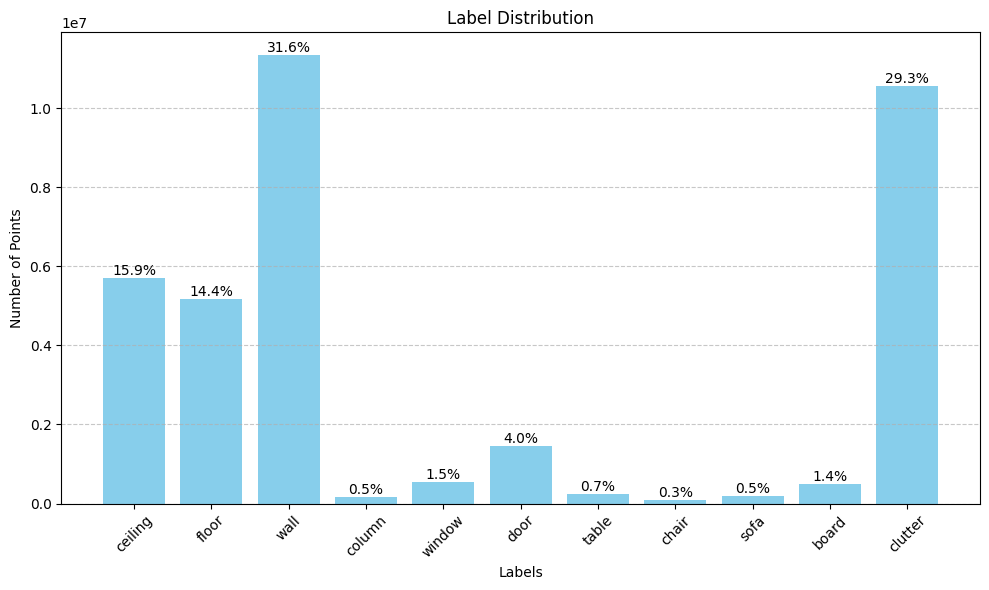

In [9]:
visualize_label_distribution(gt_labels, label_to_name)

In [6]:
def evaluation_per_class(gt_points, gt_labels, pred_file):
    results = []

    # Load predicted point cloud
    pred_pcd = o3d.io.read_point_cloud(pred_file[1])
    pred_points = np.asarray(pred_pcd.points)
    pred_colors = np.round(np.asarray(pred_pcd.colors), 1)
    pred_labels = get_label_from_color(pred_colors)

    # Filter GT labels
    valid_mask = (gt_labels != -1)
    gt_points_filtered = gt_points[valid_mask]
    gt_labels_filtered = gt_labels[valid_mask]

    # Match predicted points to GT points
    tree = cKDTree(gt_points_filtered)
    _, indices = tree.query(pred_points, k=1)
    matched_gt_labels = gt_labels_filtered[indices]

    # Compute overall accuracy separately
    overall_acc = accuracy_score(matched_gt_labels, pred_labels)
    results.append({
        "Model": pred_file[0],
        "Class": "Overall",
        "Accuracy": overall_acc,
        "Precision": None,
        "Recall": None,
        "F1": None,
        "Support": None
    })

    # Class-wise report
    report = classification_report(
        matched_gt_labels,
        pred_labels,
        output_dict=True,
        zero_division=0  # avoids divide-by-zero
    )

    for label in report:
        if label in ["accuracy", "macro avg", "weighted avg"]:
            continue
        class_id = int(label)
        metrics = report[label]
        class_name = label_to_name.get(class_id, f"Class {class_id}")
        results.append({
            "Model": pred_file[0],
            "Class": class_name,
            "Accuracy": None,
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "F1": metrics["f1-score"],
            "Support": metrics["support"]
        })

    return results


In [7]:
pred_folder = "C:/Users/yanpe/OneDrive - Metropolia Ammattikorkeakoulu Oy/Research/data/smartlab/labelled/"

prediction_files = [
    ("S3DIS_Colors", pred_folder + "Smartlab_move2corner_label_pointnet2_x6_0.03_20250704.ply"),
    ("S3DIS_No_Colors", pred_folder + "Smartlab_move2corner_label_pointnet2_x3_0.03_20250704.ply"),
    #("Simulated", pred_folder + "Smartlab_simulated_pretransform_label_pointnet2_x3_0.03_20250423.ply"),
    #("Simulated_finetuned", pred_folder + "Smartlab_aalto_pcd_finetuned_label_pointnet2_x3_0.03_20250416.ply"),
    #("LoRA_finetuned", pred_folder + "Smartlab_pcd_lora_label_pointnet2_x3_0.03_20250426.ply")
    ("Simulated", pred_folder + "Smartlab_simulated_noise_label_pointnet2_x3_0.03_20250831.ply"),
    ("Simulated_finetuned", pred_folder + "Smartlab_finetune_noise_label_pointnet2_x3_0.03_20250831.ply"),
    ("LoRA_finetuned", pred_folder + "Smartlab_pcd_lora_label_pointnet2_x3_0.03_20250831.ply")
]

In [14]:
s3dis_files = [
    ("S3DIS_Colors_original", pred_folder + "Smartlab_original_label_pointnet2_x6_0.03_20250704.ply"),
    ("S3DIS_Colors_moved", pred_folder + "Smartlab_move2corner_label_pointnet2_x6_0.03_20250704.ply"),
    ("S3DIS_No_Colors_original", pred_folder + "Smartlab_original_label_pointnet2_x3_0.03_20250704.ply"),
    ("S3DIS_No_Colors_moved", pred_folder + "Smartlab_move2corner_label_pointnet2_x3_0.03_20250704.ply"),
]

In [9]:
results = []
# Check total number of points in the ground truth file
#print(f'{len(gt_points)} points in total in the ground truth point cloud.') 

for file in prediction_files:
    #results += accuracy_per_class(gt_points,gt_labels,file)
    results += evaluation_per_class(gt_points,gt_labels,file)
    print()


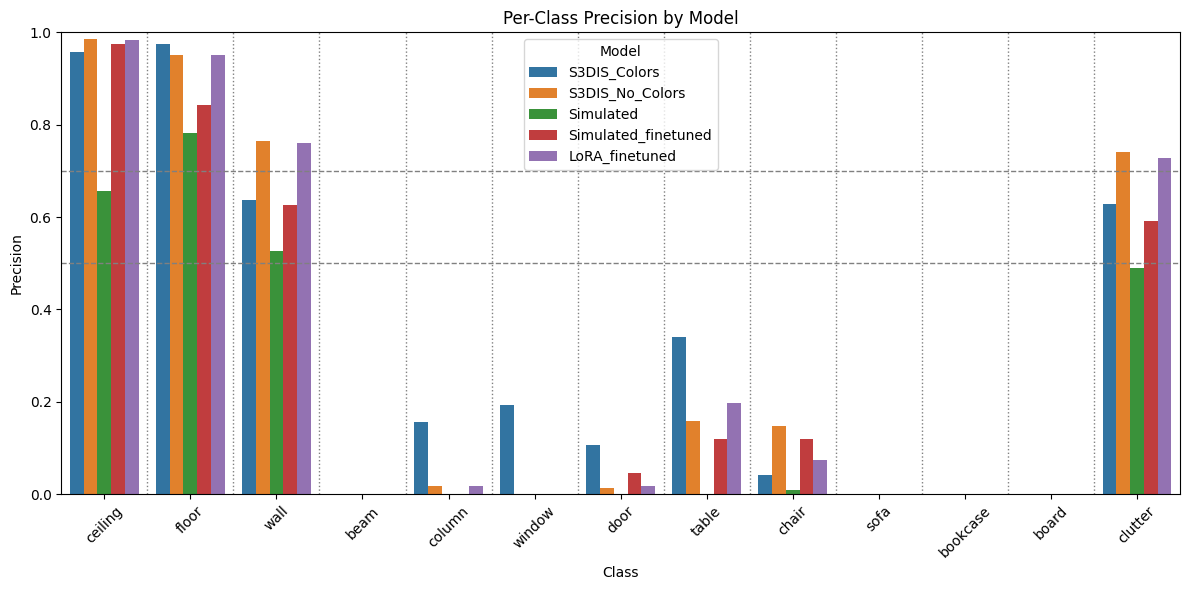

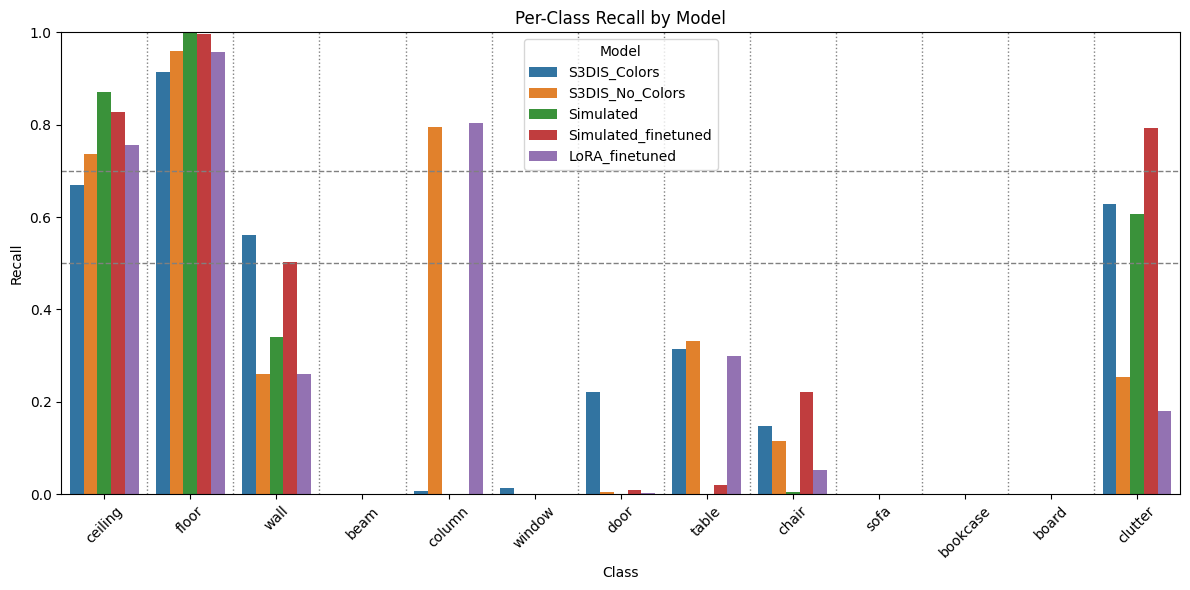

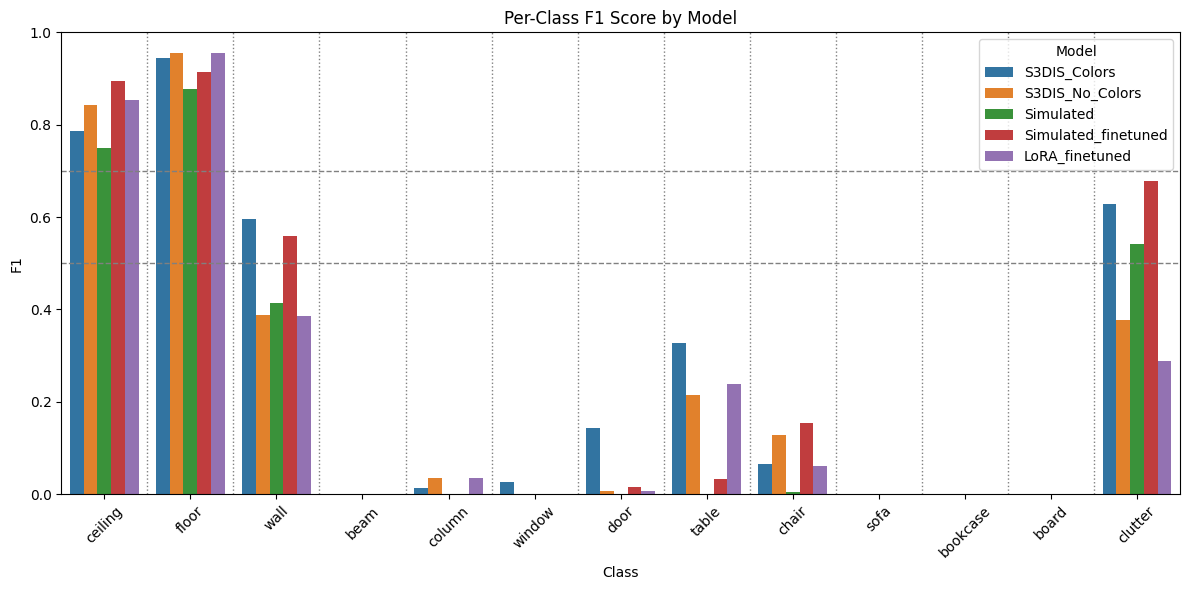

In [10]:
df = pd.DataFrame(results)
df_classes = df[df["Class"] != "Overall"]  # Exclude overall

metrics = ["Precision","Recall","F1"]
for m in metrics:   
    plt.figure(figsize=(12, 6)) 
    sns.barplot(data=df_classes, x="Class", y=m, hue="Model") 
    # Add dashed reference lines at 0.6 and 0.8
    plt.axhline(0.5, color="gray", linestyle="--", linewidth=1, label="0.6 threshold")
    plt.axhline(0.7, color="gray", linestyle="--", linewidth=1, label="0.8 threshold")
    # Add vertical separator lines between classes
    class_labels = df_classes["Class"].unique()
    for i in range(len(class_labels) - 1):
        plt.axvline(i + 0.5, color="gray", linestyle=":", linewidth=1)

    if m == "F1":
        title =  f"Per-Class {m} Score by Model"
    else: 
        title =  f"Per-Class {m} by Model"

    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()


In [30]:
df.head()

,Model,Class,Accuracy,Precision,Recall,F1,Support
0,S3DIS_Colors,Overall,0.61276,NaN,NaN,NaN,NaN
1,S3DIS_Colors,ceiling,NaN,0.957040,0.668474,0.787144,144402.0
2,S3DIS_Colors,floor,NaN,0.973989,0.914670,0.943398,121997.0
3,S3DIS_Colors,wall,NaN,0.637564,0.560449,0.596524,219260.0
4,S3DIS_Colors,beam,NaN,0.000000,0.000000,0.000000,0.0
